In [1]:
import pandas as pd
import numpy as np
import time
import os
import glob
import pickle
import bisect
import random

import matplotlib.pyplot as plt
import matplotlib

# Part 1 - Second Stage of Preprocessing

In [49]:
# functions for Saving and Loading objects to/from disc
def pickleSave(obj,name):
    with open(name+'.pkl', 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def pickleLoad(name):
    with open(name+'.pkl', 'rb') as input:
        return pickle.load(input)
    

In [3]:
# functions for converting transaction to str for txt file
def Buy2String(date,buystr,stock_name,amount): # buystr= 'open' or 'low'
    return ' '.join([date, 'buy-'+buystr, stock_name , str(amount)]) 
    
def Sell2String(date,sellstr,stock_name,amount): # sellstr= 'close' or 'high'
    return ' '.join([date, 'sell-'+sellstr, stock_name , str(amount)]) 

In [4]:
# dictionaries that contain df with min (Lows) and max (Highs) for each stock (ex. Lows['IBM'] = DataFrame)  
Lows0 = pickleLoad('LowsValid')
Highs0 = pickleLoad('HighsValid')

In [5]:
Lows0['IBM'].head(4)

,Price,Date,Volume
0,6.0373,1962-01-08,655676
2,6.0624,1962-01-19,485021
4,5.8201,1962-01-30,889207
6,5.9622,1962-02-19,341313


In [6]:
Highs0['IBM'].head(4)

,Price,Date
1,6.2376,1962-01-09
3,6.1958,1962-01-22
5,6.2209,1962-02-12
7,6.0208,1962-02-21


In [7]:
# Load Data
start_time = time.time()
df = pd.read_csv('sortedDFwithVol.csv')
print('Data loaded in', round(time.time() - start_time), 's')

Data loaded in 62 s


In [8]:
# we keep the desired columns
df = df[['Date','Open','High','Low','Close','Volume','Stock']]

In [9]:
# We keep valid values
df = df[df.Open >0]
df = df[df.High >0]
df = df[df.Low >0]
df = df[df.Close >0]
df = df[df.Volume>0]

In [10]:
df.head(1)

,Date,Open,High,Low,Close,Volume,Stock
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,GE


In [11]:
df.shape[0]

14863012

In [12]:
total_len = len(df)

#### Generation of DatetoDay, DaytoDate and DayInd.

In [13]:
# we don't need to run it again, we just pickleLoad it from next cell
"""
DayInd =[0]
DatetoDay = dict()
DaytoDate = dict()
last_day = df.Date.iat[0]
start_time = time.time()

DatetoDay[df.Date.iat[0]] = 0
DaytoDate[0] = df.Date.iat[0]
cnt= 1
for i in range(0, total_len):#total_len):
    cur_day = df.Date.iat[i]
    if cur_day > last_day:
        last_day = cur_day
        DayInd.append(i)
        DatetoDay[cur_day] = cnt
        DaytoDate[cnt] = cur_day
        cnt +=1
    if i%1000 == 0 : print('Progress: '+str(i)+' / '+str(total_len)+' = ' + str(100* i/total_len)[0:4]+' %',end ='\r')   

print("\nTime :", round(time.time() - start_time),'s', '=', round((time.time() - start_time)/60), 'min')

total_days = len(DayInd)    
DayInd.append(-1) #the day after the last day
"""

'\nDayInd =[0]\nDatetoDay = dict()\nDaytoDate = dict()\nlast_day = df.Date.iat[0]\nstart_time = time.time()\n\nDatetoDay[df.Date.iat[0]] = 0\nDaytoDate[0] = df.Date.iat[0]\ncnt= 1\nfor i in range(0, total_len):#total_len):\n    cur_day = df.Date.iat[i]\n    if cur_day > last_day:\n        last_day = cur_day\n        DayInd.append(i)\n        DatetoDay[cur_day] = cnt\n        DaytoDate[cnt] = cur_day\n        cnt +=1\n    if i%1000 == 0 : print(\'Progress: \'+str(i)+\' / \'+str(total_len)+\' = \' + str(100* i/total_len)[0:4]+\' %\',end =\'\r\')   \n\nprint("\nTime :", round(time.time() - start_time),\'s\', \'=\', round((time.time() - start_time)/60), \'min\')\n\ntotal_days = len(DayInd)    \nDayInd.append(-1) #the day after the last day\n'

In [14]:
# pickleSave(DatetoDay,'DatetoDay')
# pickleSave(DaytoDate,'DaytoDate')
# pickleSave(DayInd,'DayInd')

In [15]:
DatetoDay = pickleLoad('DatetoDay') # list that converts date (str) to an increasing unique day number for each day   
DaytoDate = pickleLoad('DaytoDate') # oppostite of DatetoDay: list that converts day number to date (str) 
DayInd = pickleLoad('DayInd') # DayInd[day] - list that tells us the index in df of the first stock record at that day   
total_days = len(DayInd)  -1 # total days of df (14084 in total)

In [16]:
#test cell
start_day = '1962-01-02'
end_day = '2017-11-10'
startD = DatetoDay[start_day]
endD = DatetoDay[end_day]

print(startD, endD, DaytoDate[14083])

0 14083 2017-11-10


#### Generation of StocksLowThatDay and StocksHighThatDay

In [17]:
# we don't need to run it again, we just pickleLoad it from next cell
"""
StocksLowThatDay = dict() # key = date value set of stock names
StocksHighThatDay = dict() # key = date value set of stock names
for d in range(total_days):
    StocksLowThatDay[d] = set()
    StocksHighThatDay[d] = set()

print('Lows')
start_time = time.time()
cnt = 1
cnt_total = len(Lows)
for stock in Lows:
    for i in range(len(Lows[stock])):
        day = DatetoDay[Lows[stock].Date.iat[i]]
        StocksLowThatDay[day].add(stock)
    if cnt %100 ==0 or cnt == cnt_total-1: print('Progress :', cnt+1,'/',cnt_total, '=',str(100*(cnt+1)/cnt_total)[0:4]+' %', end= '\r')           
    cnt+=1
print('\nTime :', round((time.time() - start_time)), 'sec')

"""

"\nStocksLowThatDay = dict() # key = date value set of stock names\nStocksHighThatDay = dict() # key = date value set of stock names\nfor d in range(total_days):\n    StocksLowThatDay[d] = set()\n    StocksHighThatDay[d] = set()\n\nprint('Lows')\nstart_time = time.time()\ncnt = 1\ncnt_total = len(Lows)\nfor stock in Lows:\n    for i in range(len(Lows[stock])):\n        day = DatetoDay[Lows[stock].Date.iat[i]]\n        StocksLowThatDay[day].add(stock)\n    if cnt %100 ==0 or cnt == cnt_total-1: print('Progress :', cnt+1,'/',cnt_total, '=',str(100*(cnt+1)/cnt_total)[0:4]+' %', end= '\r')           \n    cnt+=1\nprint('\nTime :', round((time.time() - start_time)), 'sec')\n\n"

In [18]:
"""
print('Highs')
start_time = time.time()
cnt = 1
cnt_total = len(Highs)
for stock in Highs:
    for i in range(len(Highs[stock])):
        day = DatetoDay[Highs[stock].Date.iat[i]]
        StocksHighThatDay[day].add(stock)
    if cnt %100 ==0 or cnt == cnt_total-1: print('Progress :', cnt+1,'/',cnt_total, '=',str(100*(cnt+1)/cnt_total)[0:4]+' %', end= '\r')           
    cnt+=1
print('\nTime :', round((time.time() - start_time)), 'sec')
"""

"\nprint('Highs')\nstart_time = time.time()\ncnt = 1\ncnt_total = len(Highs)\nfor stock in Highs:\n    for i in range(len(Highs[stock])):\n        day = DatetoDay[Highs[stock].Date.iat[i]]\n        StocksHighThatDay[day].add(stock)\n    if cnt %100 ==0 or cnt == cnt_total-1: print('Progress :', cnt+1,'/',cnt_total, '=',str(100*(cnt+1)/cnt_total)[0:4]+' %', end= '\r')           \n    cnt+=1\nprint('\nTime :', round((time.time() - start_time)), 'sec')\n"

In [19]:
# pickleSave(obj=StocksLowThatDay,name='StocksLowThatDay')
# pickleSave(obj=StocksHighThatDay,name='StocksHighThatDay')

In [20]:
# StocksLowThatDay[day] -> set of stock names that are active a specific day in Lows
StocksLowThatDay = pickleLoad(name='StocksLowThatDay')
StocksHighThatDay = pickleLoad(name='StocksHighThatDay')

#### Διάγραμμα εκτίμησης αριθμού μετοχών κάθε μέρα που παρουσιάζουν τοπικό ελάχιστο στην τιμή τους

Text(0.5,1,'Number of active stocks in Lows each day')

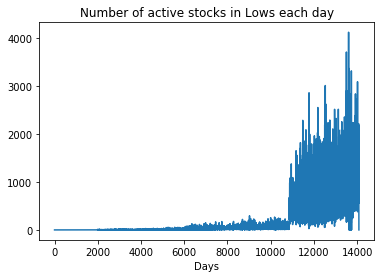

In [21]:
x = []
y = []
for d in range(0,total_days):
    x.append(d)
    y.append( len(StocksLowThatDay[d]) )
plt.plot(x,y)
plt.xlabel('Days')
plt.title('Number of active stocks in Lows each day')

    

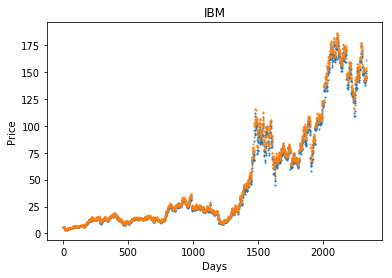

In [22]:
# s = random.choice(list(StocksLowThatDay[13300]))
s='IBM'
y1= Lows0[s].Price
y2= Highs0[s].Price
x=[]

for i in range(len(y2)):
    x.append(i)

plt.scatter(x,y1,s=1)
plt.scatter(x,y2,s=1)
plt.title(s)
plt.xlabel('Days')
plt.ylabel('Price')

plt.savefig('IBM_fig.eps', format='eps')

In [23]:
# We make Lows and Highs Sparser by a factor
def Sparsify(sparseFactor =1):
    if sparseFactor == 1:
        return([Lows0,Highs0])
    else:
        start_time = time.time()
        Lows = dict()
        Highs = dict()
        for st in Lows0:
            if len(Lows0[st]) == 0: continue # we skip that stock cause it's empty
            tempLows = Lows0[st]
            tempHighs = Highs0[st]
            #     temp = temp[(temp.index<1000) | (temp.index%sparseFactor == 0) ]
            tempLows = tempLows[(tempLows.index%sparseFactor == 0) ]
            tempHighs = tempHighs[( (tempHighs.index-1)%sparseFactor == 0) ]

            # Change Indexes
            L = len(tempLows)
            tempind = []
            for i in range(L):
                tempind.append(i*2)

            indexNamesLows = tempLows.index.values
            indexNamesHighs = tempHighs.index.values
            for i in range(L):
                indexNamesLows[i] = tempind[i]
                indexNamesHighs[i] = tempind[i]+1
            #     del indexNamesLows, indexNamesHighs 

            Lows[st] = tempLows
            Highs[st] = tempHighs
        print('Time :', int(time.time() - start_time),'sec')
        return([Lows,Highs])

In [24]:
res = Sparsify(sparseFactor=1) # for sparseFactor=1 we keep everything unchanged
Lows , Highs = res[0], res[1]

### Preview of Sparsify Function

Time : 7 sec


Text(0,0.5,'Price')

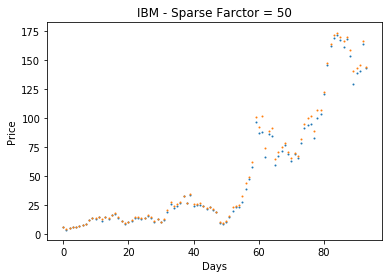

In [25]:
# s = random.choice(list(StocksLowThatDay[10000]))
res = Sparsify(sparseFactor=50) # for sparseFactor=1 we keep everything
Lows_temp , Highs_temp = res[0], res[1]
s='IBM'
y1= Lows_temp[s].Price
y2= Highs_temp[s].Price
x=[]
for i in range(len(y2)):
    x.append(i)

plt.scatter(x,y1,s=1)
plt.scatter(x,y2,s=1)
plt.title(s+' - Sparse Farctor = 50')
plt.xlabel('Days')
plt.ylabel('Price')

Παρατηρούμε ότι διατηρείται η μορφή της γραφικής αλλά έχει λιγότερα σημεία. Με αυτό τον τρόπο ο χρόνος της επεξεργασίας μειώνεται.

# Part 2 - Class and Function Definitions

### Our Class which contains our transactions history

In [26]:
class Possesions:
    def __init__(self):
        self.Balance = dict() # key = day, value = myBalance for each day
        self.BalanceNow = 1
        self.Stocks = dict(dict()) # key = day, value = dict(key = stock, value = [amount, total_value]) (total_value = amount*price)   
        self.CurrentStocks = dict([]) # key = stock, value = [amount, total_value]
        self.Moves = []
           
            
    def buy(self,day,stock_name,buy_price, buystr, amount):
        estim_price = buy_price
        self.BalanceNow -=  amount*buy_price
        self.Balance[day] = self.BalanceNow  
        
        if stock_name not in self.CurrentStocks: self.CurrentStocks[stock_name] = [0,0]
        self.CurrentStocks[stock_name][0] += amount
        self.CurrentStocks[stock_name][1] = self.CurrentStocks[stock_name][0]*estim_price
        
        if day not in  self.Stocks:  self.Stocks[day] = dict()
        if stock_name not in self.Stocks[day]: self.Stocks[day][stock_name] =  [0,0]
        self.Stocks[day][stock_name][0] = self.CurrentStocks[stock_name][0]
        self.Stocks[day][stock_name][1] = self.CurrentStocks[stock_name][1]
        
        trans = Buy2String(DaytoDate[day], buystr, stock_name, int(amount))
        self.Moves.append(trans)
        
         
    def sell(self, day, stock_name, sell_price, sellstr, amount):
        self.BalanceNow +=  amount*sell_price
        self.Balance[day] = self.BalanceNow  
        
        if stock_name not in self.CurrentStocks: self.CurrentStocks[stock_name] = [0,0]
        self.CurrentStocks[stock_name][0] -= amount
        self.CurrentStocks[stock_name][1] = self.CurrentStocks[stock_name][0]*sell_price
        
        if day not in  self.Stocks:  self.Stocks[day] = dict()
        if stock_name not in self.Stocks[day]: self.Stocks[day][stock_name] =  [0,0]
        self.Stocks[day][stock_name][0] = self.CurrentStocks[stock_name][0]
        self.Stocks[day][stock_name][1] = self.CurrentStocks[stock_name][1]
        
        if int(self.CurrentStocks[stock_name][0]) == 0 : 
            del self.CurrentStocks[stock_name]
            del self.Stocks[day][stock_name]
            if self.Stocks[day] == dict(): del self.Stocks[day]

        trans = Sell2String(DaytoDate[day], sellstr, stock_name, int(amount))
        self.Moves.append(trans)

### Greedy Intraday Transactions Function

In [27]:
def GreedyIntraday(Nmax = 1000, start_day =0, end_day = total_days-1, day_step = 1, maxStockspDay = 1, message = True, ConsiderVol = True):     # Nmax = megistos # kinhsewn
    global myBalance
    time_limit = 5* 60 * 60
    N = 0 # current move number
    day = start_day 
    total_len = len(df)
    start_time = time.time()
    
    if message: print('Intraday Transactions Started...\n')
    
    while (N<=Nmax-2 and day<=end_day):
        maxprofits = [0] # ascending list with profits each day
        maxindexes,maxbuys,maxbuystrings,maxsells,maxsellstrings = [0],[0],[0],[0],[0]
        maxamounts = [0]
        
        nextDInd = DayInd[day+1]
        if nextDInd == -1 : nextDInd == total_len
        temp_bal  = myBalance # balance during the day 
        
        Nst = 1 # Nst = # of stock that day
        for i in range(DayInd[day], nextDInd): # at that day find the stocks with max profit that we can afford  
            op , high , low , cl = df.Open.iat[i] , df.High.iat[i] , df.Low.iat[i] , df.Close.iat[i]
            t1 = high - op  # early transaction
            t2 = cl - low  # late transaction
            
            amount1 , amount2 = int(myBalance//op) , int(myBalance//low)
            Vol = df.Volume.iat[i]
            if amount1>=Vol: amount1=Vol
            if amount2>=Vol: amount2=Vol                
            profit1 , profit2 = t1*amount1 , t2*amount2          
            
            entered = False
            if profit1 >= profit2 and profit1>0:
                imax, buy, buystr, sell, sellstr, maxprofit = i, op, 'open', high, 'high', profit1
                amount, entered = amount1 , True
            elif profit2 >= profit1 and profit2>0:
                imax, buy, buystr, sell, sellstr, maxprofit = i, low, 'low', cl, 'close', profit2       
                amount , entered = amount2 , True
            
            if entered and buy<myBalance and maxprofit>maxprofits[0]:
                ind = bisect.bisect(maxprofits, maxprofit)
                maxprofits.insert(ind,maxprofit)
                maxindexes.insert(ind,imax)
                maxbuys.insert(ind, buy)
                maxbuystrings.insert(ind,buystr)
                maxsells.insert(ind, sell)
                maxsellstrings.insert(ind,sellstr)
                maxamounts.insert(ind,amount)
                
                while maxprofits[0] == 0:
                    del maxprofits[0], maxindexes[0]
                    del maxbuys[0],maxbuystrings[0],maxsells[0],maxsellstrings[0],maxamounts[0] 
                    Nst -= 1

        if maxprofits[-1] > 0: #there is at least one good intraday transaction
            for k in range(len(maxprofits)-1, -1, -1): # iterate through maxprofits starting from the end 
                buy  = maxbuys[k]
                amountlimit = maxamounts[k]
                temp_amount = int(temp_bal // buy)
                amount = min(amountlimit, temp_amount)

                if amount > 0:
                    imax = maxindexes[k]
                    buystr, sell, sellstr = maxbuystrings[k], maxsells[k], maxsellstrings[k]
                    stock_name = df.Stock.iat[imax]
                    MY.buy(day,stock_name, buy,buystr, amount) # day,stock_name,buy_price, buystr, amount
                    MY.sell(day,stock_name, sell,sellstr, amount)  # day, stock_name, sell_price, buystr, amount    
                    N += 2
                    Nst += 1
                    myBalance += (sell-buy)*amount
                    temp_bal -= amount*buy
                else: break
                
                if maxStockspDay>0: 
                    if Nst>= maxStockspDay:break            
            
        
        day += day_step
        if message:
            if ((day>6000 and day%10 ==0) or day == end_day or N == Nmax): 
                print('Day:', day,'/',end_day,'- Transaction Progress :',N,' - Balance:',str(myBalance)[0]+' x 10^'+str(len(str(int(myBalance)))-1)+' $' ,end='\r')      
    
    if message:
        print()
        print('Time :', round(time.time() - start_time), 'sec =',round((time.time() - start_time)/60), 'min')
        if myBalance<10:
            first_dig_rounded, first_dig = str(round(myBalance*10)//10), str(int(myBalance))
        else:
            first_dig_rounded = str(round(int((str(int(myBalance))[0:2]))/10))
            first_dig = str(int(myBalance))[0]
        bal = first_dig_rounded + ' x 10^' + str(len( str(int(myBalance)))-1) +' $'
        print('My Balance = ', bal, 'in',N,'moves (' + str( int(myBalance)) + ' $)')
        print('Total Moves until now:',len(MY.Moves))
        if day>=total_days: day=total_days-1
        print('Stopped at:', DaytoDate[day]  +', which is day:' , day+1, '/', total_days)
        print('\n...Intraday Transactions Finished\n \n')
    
    return(day)


### Intraday Single Transaction Function

In [28]:
def Intraday(Nmax = 1000, start_day =0, end_day = total_days-1, day_step = 1, message = True, ConsiderVol = True):     # Nmax = megistos # kinhsewn
    global myBalance
    time_limit = 5* 60 * 60
    N = 0 # current move number
    day = start_day 
    total_len = len(df)
    start_time = time.time()
    
    if message: print('Intraday Transactions Started...\n')
    
    while (N<=Nmax-2 and day<=end_day):
        imax = -1
        maxprofit = 0
        nextDInd = DayInd[day+1]
        if nextDInd == -1 : nextDInd == total_len
        for i in range(DayInd[day], nextDInd): # at that day find the stock with max profit that we can afford  
            op = df.Open.iat[i] 
            high =  df.High.iat[i]  
            low =  df.Low.iat[i]  
            cl =  df.Close.iat[i]

            t1 = high - op  # early
            t2 = cl - low  # late
            
            amount1 = int(myBalance//op)
            amount2 = int(myBalance//low)
            if ConsiderVol:
                Vol = df.Volume.iat[i]
                if amount1>=Vol: amount1=Vol
                if amount2>=Vol: amount2=Vol                
            profit1 = t1*amount1            
            profit2 = t2*amount2
            
            if profit1 >= profit2 and profit1>maxprofit:
                imax, buy, buystr, sell, sellstr, maxprofit = i, op, 'open', high, 'high', profit1
                amount = amount1
            elif profit2 >= profit1 and profit2>maxprofit:
                imax, buy, buystr, sell, sellstr, maxprofit = i, low, 'low', cl, 'close', profit2       
                amount = amount2

        if maxprofit > 0:
            stock_name = df.Stock.iat[imax]

            MY.buy(day,stock_name,buy,buystr,amount) # day,stock_name,buy_price, buystr, amount
            MY.sell(day,stock_name, sell,sellstr, amount)  # day, stock_name, sell_price, buystr, amount    
            N += 2
            myBalance += maxprofit

        day += day_step
        if message:
            if ((day>6000 and day%10 ==0) or day == end_day or N == Nmax): print('Day:', day,'/',end_day, '- Transaction Progress :', N,end='\r')      
        
    if message:
        print()
        print('Time :', round(time.time() - start_time), 'sec =',round((time.time() - start_time)/60), 'min')
        if myBalance<10:
            first_dig_rounded, first_dig = str(round(myBalance*10)//10), str(int(myBalance))
        else:
            first_dig_rounded = str(round(int((str(int(myBalance))[0:2]))/10))
            first_dig = str(int(myBalance))[0]
        bal = first_dig_rounded + ' x 10^' + str(len( str(int(myBalance)))-1) +' $'
        print('My Balance = ', bal, 'in',N,'moves (' + str( int(myBalance)) + ' $)')
        print('Total Moves until now:',len(MY.Moves))
        if day>=total_days: day=total_days-1
        print('Stopped at:', DaytoDate[day]  +', which is day:' , day+1, '/', total_days)
        print('\n...Intraday Transactions Finished\n \n')
    
    return(day)

### Early Days Transactions Function

In [29]:
# Early Days Transactions Function

def EarlyDayMoves(Nmax, days_per_win, start_day=0, message= True, ConsiderVol = True):
    global myBalance
    start_time = time.time()
    
    res = CreateEarlyWindows(Nmax, days_per_win)
    startDays = res[0]
    endDays = res[1]
    
    N = 0 # current move number
    if message: print('Early Days Transactions Started...\n')
    start_time = time.time()
    windows = len(startDays)    
    for win in range(windows):
        # Window ========================================================================================
        startD = startDays[win] # first = 0
        endD = endDays[win] # last = 14083
        startind, endind = DayInd[startD], DayInd[endD+1]-1
        
        maxprofit = 0
        for i in range(startind,endind): # i is the index of low (buy)
            name = df.Stock.iat[i]
            low = df.Low.iat[i]
            amount = int(myBalance//low)
            
            if amount > 0 and myBalance >low:
                if ConsiderVol:
                    vol = df.Volume.iat[i]
                if amount > vol: amount = vol
                    
                for j in range(i+1,endind+1): # j is the index of high (sell)
                    temp_name = df.Stock.iat[j]
                    if temp_name == name:
                        high = df.High.iat[j]
                        dif = high - low
                        profit = amount*dif
                        if profit > maxprofit:
                            maxprofit , imax , jmax = profit , i , j
                            buy_price , sell_price = low , high
                            maxamount , maxname = amount , name
    
        if maxprofit > 0:
            N+=2
            buydate , selldate = df.Date.iat[imax] , df.Date.iat[jmax]
            buyday, sellday = DatetoDay[buydate], DatetoDay[selldate]            

            MY.buy(buyday, maxname, buy_price, 'low',maxamount) #(day,stock_name,buy_price,buystr, amount)  
            myBalance -= maxamount*buy_price

            MY.sell(sellday, maxname, sell_price, 'high', maxamount)
            myBalance += maxamount*sell_price
            
            
        if win%1==0 or win == windows-1: 
            print('Window :', win+1, '/',windows,'- Time :', int(time.time() - start_time),'sec =',int((time.time() - start_time)//60),'min',end='\r')   
    print()
    if myBalance<10:
        first_dig_rounded, first_dig = str(round(myBalance*10)//10), str(int(myBalance))
    else:
        first_dig_rounded = str(round(int((str(int(myBalance))[0:2]))/10))
        first_dig = str(int(myBalance))[0]
    bal = first_dig_rounded + ' x 10^' + str(len( str(int(myBalance)))-1) +' $'
    print('My Balance = ', bal, 'in',N,'moves (' + str( int(myBalance)) + ' $)')
    print('Total Moves until now:',len(MY.Moves))
    print('Stopped at:', DaytoDate[endD]  +', which is day:' , endD+1, '/', total_days)
    print('\n...Early Day Transactions Finished\n \n')
    
    return(endD)

In [30]:
def CreateEarlyWindows(Nmax, days_per_win, start_day=0): # time windows for the first moves
    windows = int(Nmax//2)
    if windows*days_per_win> total_days: 
        print('Not enough days in DF')
        return(None)
    startDays, endDays = [], []
    for w in range(windows):
        startDays.append(start_day + w*days_per_win)
        endDays.append(start_day + (w+1)*days_per_win -1)
    return([startDays,endDays])
    

In [31]:
## test cell 
# c =CreateEarlyWindows(Nmax=100, days_per_win=10)
# a,b = c[0],c[1]
# print(a,'\n',b)

### Min Max Transactions Function

In [32]:
# Min-Max Moves
def MinMaxMoves(Nmax, start_day, end_day, message = True, ConsiderVol = True):
    global myBalance
    
    N = 0 # current move number
    res = CreateWindows(Nmax, start_day, end_day)
    startDays = res[0]
    endDays = res[1]
    
    if message: print('MinMax Transactions Started...\n')
    start_time = time.time()
    windows = len(startDays)    
    for win in range(windows):
        # Window ===============================================================================================
        startD = startDays[win] # first = 0
        endD = endDays[win] # last = 14083

        StocksInWindow = set()
        for day in range(startD,endD+1):
            StocksInWindow = StocksInWindow.union(StocksLowThatDay[day])

        maxprofit = 0 # max (high - low)*amount
        for st in StocksInWindow:
            # Find index limits (start_ind of Lows, end_ind of Highs)-------------------------------------------
            start_ind_temp = Lows[st][Lows[st].Date >= DaytoDate[startD]].index.tolist()
            if start_ind_temp != []: 
                start_ind = start_ind_temp[0]
            else:
                continue # we skip that stock   

            end_ind_temp = Highs[st][Highs[st].Date <= DaytoDate[endD] ].index.tolist()
            if end_ind_temp != []: 
                end_ind = end_ind_temp[-1]
            else:
                continue

            if start_ind >= end_ind: continue
            # -----------------------------------------------------------------------------------
            ilow = start_ind # index of Lows
            ihigh = ilow+1 # index of Highs
            low = Lows[st].Price.iat[ilow//2] # or .at[ilow]
            lowest = low

            stop = False
            while stop == False: 
        #         low = Lows[st].Price.iat[ilow//2]
                high =  Highs[st].Price.iat[ihigh//2]
                if low<lowest: lowest = low
                dif = high - low
                amount = int(myBalance//low)
                if ConsiderVol:
                    vol = Lows[st].Volume.iat[ilow//2]
                    if amount>vol: amount = vol
                profit = amount*dif
                
                if amount>0 and profit > maxprofit:
                    maxprofit = profit
                    buy_sell_name , maxamount = st , amount
                    buydate, selldate = Lows[st].Date.iat[ilow//2], Highs[st].Date.iat[ihigh//2]
                    buy_price, sell_price = low, high

                if ihigh<end_ind:
                    nextlow = Lows[st].Price.iat[(ihigh+1)//2]
                    if nextlow < lowest:
                        ihigh += 2
                        ilow = ihigh - 1
                        low = nextlow
                    else:
                        ihigh += 2
                else:
                    stop = True
                    
        if maxprofit>0: # do the transaction
            N+=2
            buyday, sellday = DatetoDay[buydate], DatetoDay[selldate]
            
            MY.buy(buyday, buy_sell_name, buy_price, 'low',maxamount) #(day,stock_name,buy_price,buystr, amount)  
            myBalance -= maxamount*buy_price

            MY.sell(sellday, buy_sell_name, sell_price, 'high', maxamount)
            myBalance += maxamount*sell_price
        # Window End ==========================================================================================  
        if message and (win%10==0 or startD>10000 or win == windows-1 ): print('Window :', win+1, '/',windows,'- Time :', int(time.time() - start_time), 'sec =',int((time.time() - start_time)//60),'min'  ,end='\r')

    if message:
        print('\nTotal Min-Max Moves Time :', int(time.time() - start_time), 'sec')
        if myBalance<10:
            first_dig_rounded, first_dig = str(round(myBalance)), str(round(myBalance))
        else:
            first_dig_rounded = str(round(int((str(int(myBalance))[0:2]))/10))
            first_dig = str(int(myBalance))[0]
        bal = first_dig + ' x 10^' + str(len( str(int(myBalance)))-1) +' $'
        print('My Balance = ', bal, 'in',N,'moves (' + str( int(myBalance)) + ' $)')
        print('Total Moves until now:',len(MY.Moves))
        print('Stopped at:', DaytoDate[endD]  +', which is day:' , endD+1, '/', total_days)
        print('\n...Min Max Transactions Finished\n \n')
    

In [33]:
# create time windows for MinMaxMoves Function
def CreateWindows(Nmax, start_day = 0, end_day= total_days-1):
    num_of_windows = Nmax//2
    startDays, endDays = [], []
    
    tot_days = end_day - start_day + 1
    days_per_window = tot_days // num_of_windows
    
    for i in range(num_of_windows):
        startDays.append( start_day + i*days_per_window)
        endDays.append( start_day + (i+1)*days_per_window - 1)
    
    endDays[-1] = end_day
    return([startDays, endDays])  

### Create TXT File Function

In [34]:
# create txt output file for submission at "https://courses.softlab.ntua.gr/progds/2018b/time-travel/"
def CreateTXT(file_name):
    file = open(file_name+".txt", "w+") 
    totMoves = len(MY.Moves)
    file.write(str(totMoves)) 
    for i in range(totMoves):
         file.write('\n' + MY.Moves[i])
    file.close() 

### Plot Functions

In [35]:
def findIndex(day,stock_name):
    istart = DayInd[day]
    if day == total_days-1:
        iend = total_len-1
    else:
        iend = DayInd[day+1]
    
    for i in range(istart,iend+1):
        if df.Stock.iat[i] == stock_name: return(i)
    return(None)
            
    

In [36]:
# total_days = 14084

In [37]:
def BalPortfProgress():
    start_time = time.time()
    print('Creating Balance and Portfolio Progress through the years...')
    bal = [1]
    portf = [1] # balance + total value of my stocks each day
    for d in range(0,total_days):
        if d not in MY.Balance:
            bal.append(bal[-1])
        else:
            bal.append(MY.Balance[d])

        if d not in MY.Stocks: MY.Stocks[d] = dict()
        if d < total_days-1:
            for inactiveStock in MY.Stocks[d]:
                if MY.Stocks[d][inactiveStock] != []:
                    temp_amount = MY.Stocks[d][inactiveStock][0]
                    if d+1 not in MY.Stocks:MY.Stocks[d+1] = dict()
                    if inactiveStock not in MY.Stocks[d+1] and  temp_amount>=1: 
                        MY.Stocks[d+1][inactiveStock] = [temp_amount,0]

                        ind = findIndex(d,inactiveStock)
                        i = 1
                        while ind == None: # if is it a missing value we get the lastday it wasn't missing
                            ind = findIndex(d-i,inactiveStock)
                            i += 1
                        temp_price = df.Close.iat[ind]
                        MY.Stocks[d+1][inactiveStock][1] = temp_amount * temp_price

        sum0 = 0
        for st in MY.Stocks[d]:
            if MY.Stocks[d] != dict():
                if MY.Stocks[d][st] != []:
                    sum0 +=  MY.Stocks[d][st][1]

        portf.append(sum0 + bal[-1]) 

        if d % 100 ==0 or d == total_days-1: print('Progress: ' +str(d+1)+' / '+str(total_days)+' = ' + str(100* (d+1)/total_days)[0:4]+' %'+' - Time :', round((time.time() - start_time)/60),'min' ,end ='\r')         

    print()
    print('Finished in :', time.time()-start_time, 'sec \n')
    
    return(bal, portf)

In [38]:
def PlotAll(bal,portf,fig_name):
    start_time = time.time()
    print('Plot')
    print('Converting to Arrays...')
    x= np.array([i for i in range(0,total_days+1)])
    y = np.array(bal)
    y2 = np.array(portf) 

    print('Conversion Finished in :', time.time() - start_time, 'sec')
    
    # Plot Ticks===========================================================
    first_year = df.Date.iat[DayInd[0]][0:4]
    last_year = df.Date.iat[DayInd[-2]][0:4]
    num_ticks = int(last_year) - int(first_year) +1  # number of years

    for i in range(total_days -1,0,-1):
        if df.Date.iat[DayInd[i]][0:4] < last_year:
            LYsFD = i+1 # last year's first day
            break

    step = LYsFD/num_ticks
    tick_locations = [int(i) for i in np.arange(0,LYsFD+1,step)]

    tick_labels= []
    temp= int(first_year)
    for i in range(num_ticks):
        tick_labels.append(temp)
        temp += 1
    
    if len(tick_labels) >10:
        year_step = 10 # Time duration between ticks
    else:
        year_step = 5

    temp_loc = []
    temp_labels =[]
    for i in range(0,len(tick_labels),year_step):
        temp_loc.append(tick_locations[i])
        temp_labels.append(tick_labels[i])

    tick_locations = temp_loc
    tick_labels = temp_labels
    #==================================================================================
    
    # PLOT=============================================================================
    plt.plot(x, y)
    plt.yscale(value='log')
    plt.fill_between(x,y,label='Balance')
    # plt.plot(x, y2,label='Portfolio')
    plt.fill_between(x,y2,y,label='Portfolio')
    # plt.fill_between(x,y2,y,where=(y2>=y),label='Portfolio')

    # plt.legend(loc='best')
    plt.legend(loc='upper left')
    plt.xticks(tick_locations, tick_labels)
    plt.title('Valuation')
    plt.savefig(fig_name+'_fig.eps', format='eps')
    #==================================================================================
    

# Part 3 - Run

### Large.txt - Greedy Intraday Transactions

In [39]:
MY = Possesions()
myBalance =1

GreedyIntraday(Nmax=10**6, maxStockspDay = 40)

Intraday Transactions Started...

Day: 14083 / 14083 - Transaction Progress : 773906  - Balance: 5 x 10^12 $
Time : 1547 sec = 26 min
My Balance =  5 x 10^12 $ in 773906 moves (5306940094972 $)
Total Moves until now: 773906
Stopped at: 2017-11-10, which is day: 14084 / 14084

...Intraday Transactions Finished
 



14083

In [40]:
CreateTXT('large')

In [41]:
pickleSave(obj=MY,name='MY_large')

Creating Balance and Portfolio Progress through the years...
Progress: 14084 / 14084 = 100. % - Time : 0 min
Finished in : 0.6510374546051025 sec 

Plot
Converting to Arrays...
Conversion Finished in : 0.011000394821166992 sec


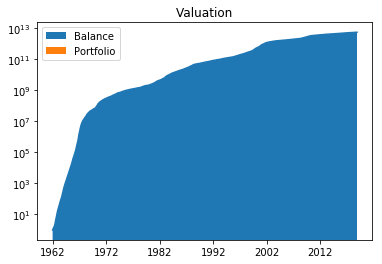

In [51]:
res = BalPortfProgress()
bal , portf = res[0], res[1]
PlotAll(bal,portf,fig_name='Large')

# pickleSave(obj=bal,name='bal_small')
# pickleSave(obj=portf,name='portfolio_small')

### Small.txt - Combination of EarlyDayMoves and MinMaxMoves

In [43]:
MY = Possesions()
myBalance =1

# EarlyDayMoves we want to it to keep it runnins as long as posible and then continue with MinMaxMoves for the rest of the moves       
lastDAY = EarlyDayMoves(Nmax=400, days_per_win=30 ) # 2 moves per window
# Min Max Moves
MinMaxMoves(Nmax=600, start_day = lastDAY, end_day=total_days-1, ConsiderVol=True) # last day = 14083

Early Days Transactions Started...

Window : 200 / 200 - Time : 4800 sec = 80 min 200 - Time : 0 sec = 0 min
My Balance =  4 x 10^9 $ in 400 moves (4287434609 $)
Total Moves until now: 400
Stopped at: 1985-11-14, which is day: 6000 / 14084

...Early Day Transactions Finished
 

MinMax Transactions Started...

Window : 300 / 300 - Time : 898 sec = 14 min
Total Min-Max Moves Time : 898 sec
My Balance =  2 x 10^11 $ in 600 moves (295855436009 $)
Total Moves until now: 1000
Stopped at: 2017-11-10, which is day: 14084 / 14084

...Min Max Transactions Finished
 



In [44]:
CreateTXT('small')

In [45]:
pickleSave(obj=MY,name='MY_small')

Plot
Converting to Arrays...
Conversion Finished in : 0.007000446319580078 sec


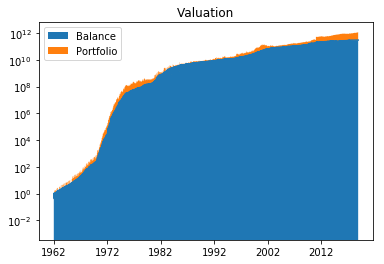

In [49]:
res = BalPortfProgress()
bal , portf = res[0], res[1]
PlotAll(bal,portf,fig_name='Small')

In [47]:
# pickleSave(obj=bal,name='bal_small')
# pickleSave(obj=portf,name='portfolio_small')

### Example

In [40]:
MY = Possesions()
myBalance =1

In [41]:
MY.buy(DatetoDay['1962-06-27'], 'GE', 0.45902, 'low', 2 )
MY.sell(DatetoDay['1965-12-31'], 'GE', 0.9984, 'high', 2)
MY.buy(DatetoDay['1970-05-27'], 'GE', 0.49892, 'low', 4 )


Creating Balance and Portfolio Progress through the years...
Progress: 14084 / 14084 = 100. % - Time : 2 min
Finished in : 128.58235383033752 sec 

Plot
Converting to Arrays...
Conversion Finished in : 0.003000020980834961 sec


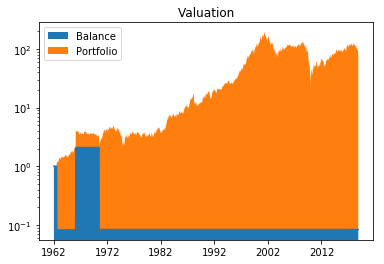

In [42]:
res = BalPortfProgress()
bal , portf = res[0], res[1]
PlotAll(bal,portf,fig_name='GE_test')